<a href="https://colab.research.google.com/github/molinacle/Portafolio/blob/main/Predicci%C3%B3n_Precios_Casas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
import math

In [ ]:
# Cargar el dataset
data = pd.read_excel('data-housing.xlsx')

In [ ]:
data.head()

,price,area,bedrooms,bathrooms,stories,guestroom,hotwaterheating,airconditioning,parking
0,13300000,7420,4,2,3,no,no,yes,2
1,12250000,8960,4,4,4,no,no,yes,3
2,12250000,9960,3,2,2,no,no,no,2
3,12215000,7500,4,2,2,no,no,yes,3
4,11410000,7420,4,1,2,yes,no,yes,2


#Etapa 2: Comprensión de los Datos
1. Importar Librerías y Cargar Datos

In [ ]:
# Obtener valores únicos
valores_unicos_categorica = data['guestroom'].unique()
print(f'Valores únicos en la columna guestroom: {valores_unicos_categorica}')

valores_unicos_categorica = data['hotwaterheating'].unique()
print(f'Valores únicos en la columna hotwaterheating: {valores_unicos_categorica}')

valores_unicos_categorica = data['airconditioning'].unique()
print(f'Valores únicos en la columna airconditioning: {valores_unicos_categorica}')

Valores únicos en la columna guestroom: ['no' 'yes']
Valores únicos en la columna hotwaterheating: ['no' 'yes']
Valores únicos en la columna airconditioning: ['yes' 'no']


2. Análisis Exploratorio de Datos (EDA)

Resumen de los Datos

In [ ]:
# Información general del dataset
print(data.info())

# Resumen estadístico del dataset
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   price            545 non-null    int64 
 1   area             545 non-null    int64 
 2   bedrooms         545 non-null    int64 
 3   bathrooms        545 non-null    int64 
 4   stories          545 non-null    int64 
 5   guestroom        545 non-null    object
 6   hotwaterheating  545 non-null    object
 7   airconditioning  545 non-null    object
 8   parking          545 non-null    int64 
dtypes: int64(6), object(3)
memory usage: 38.4+ KB
None
              price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  545.000000  545.000000   
mean   4.766729e+06   5150.541284    2.965138    1.286239    1.805505   
std    1.870440e+06   2170.141023    0.738064    0.502470    0.867492   
min    1.750000e+06   1650.000000    1.000000    1.00

Distribución de la Variable Objetivo

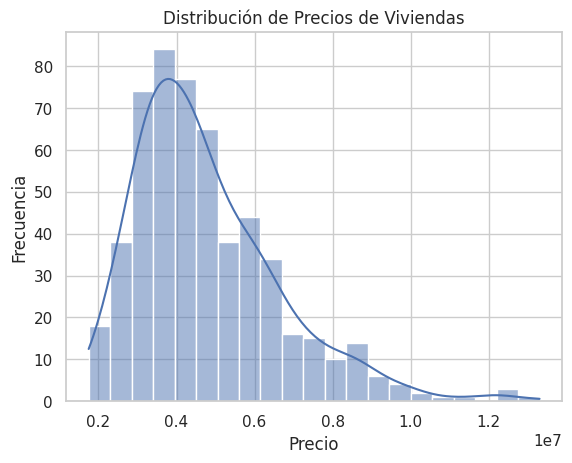

In [ ]:
# Histograma de la variable objetivo 'precio'
sns.histplot(data['price'], kde=True)
plt.title('Distribución de Precios de Viviendas')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

Visualización de Relaciones entre Variables

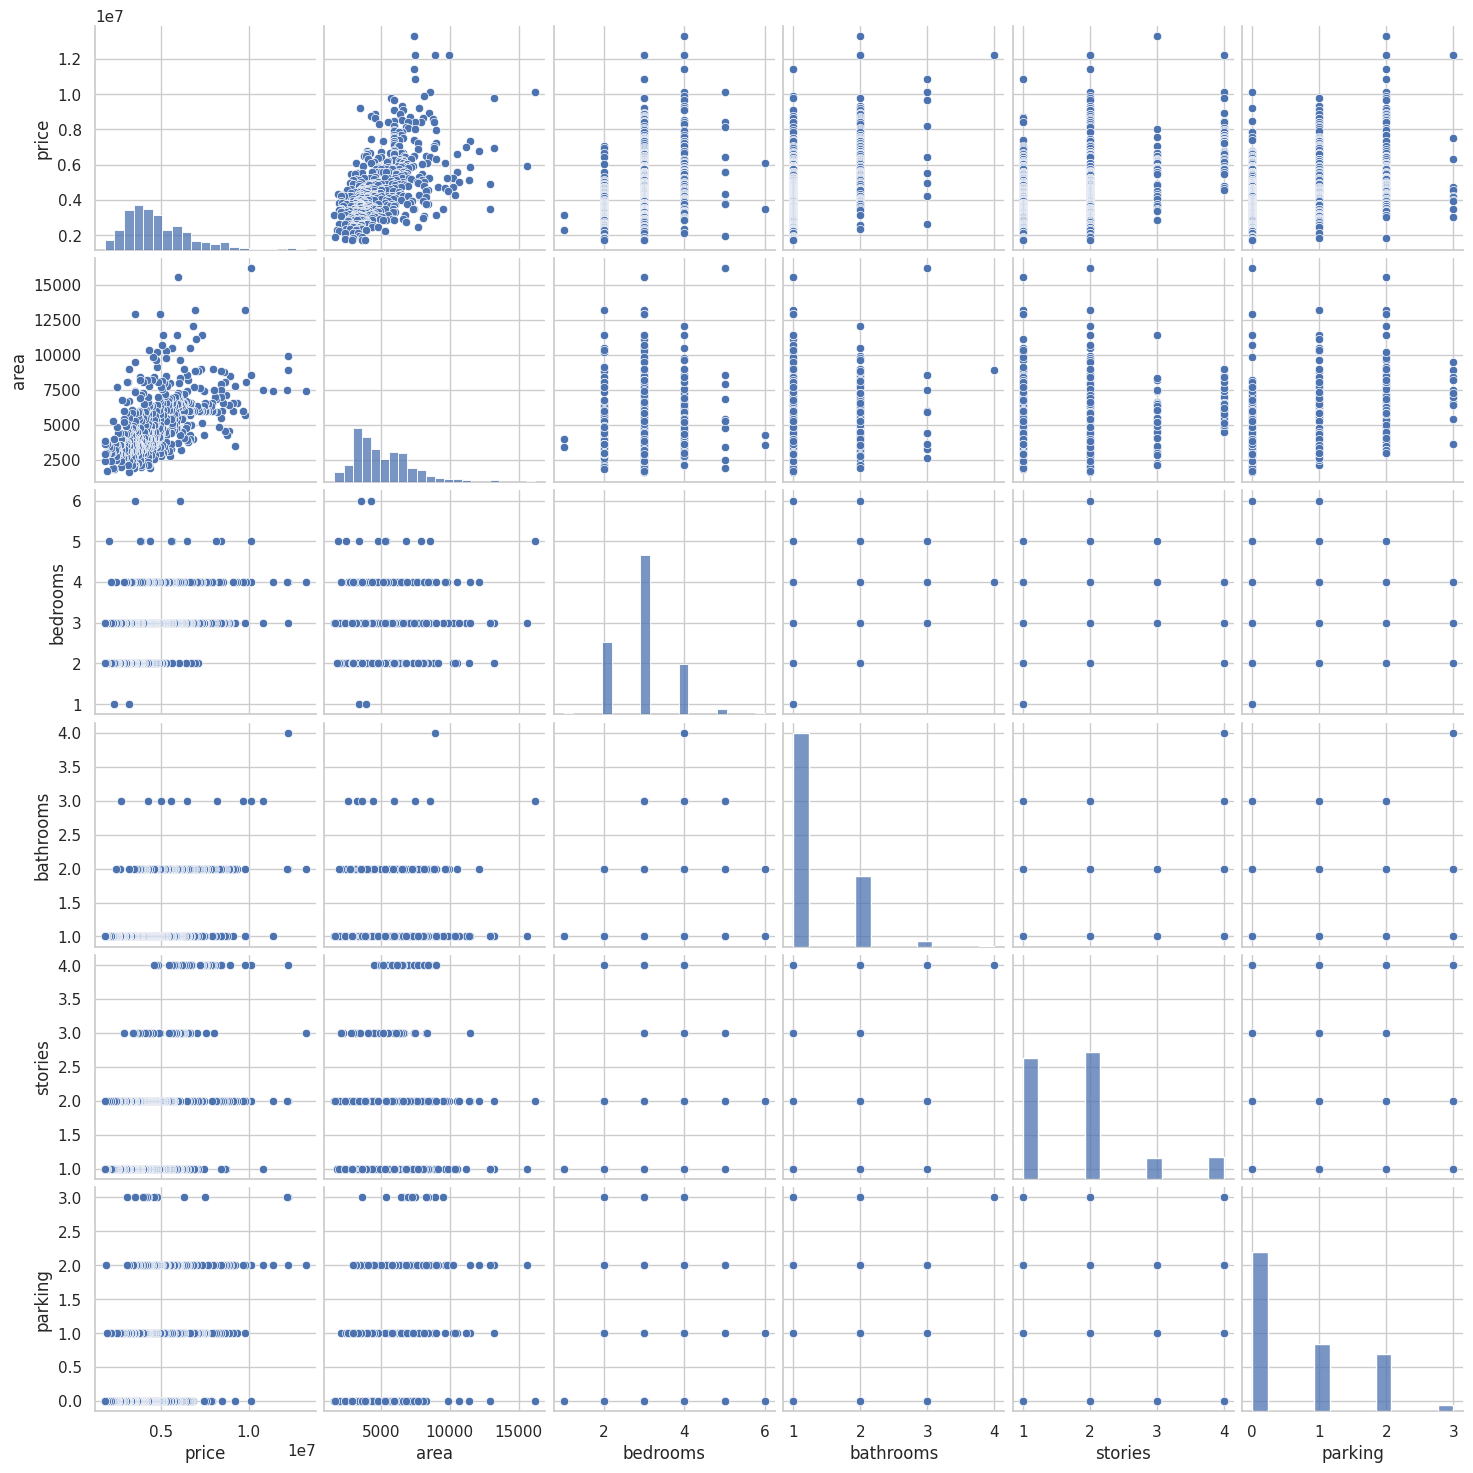

In [ ]:
# Gráficos de dispersión para identificar relaciones entre variables
sns.pairplot(data)
plt.show()

Matriz de Correlación

In [ ]:
# Convertir 'yes' a 1 y 'no' a 0 en todas las columnas especificadas
columnas_a_convertir = ['guestroom', 'hotwaterheating', 'airconditioning']
data[columnas_a_convertir] = data[columnas_a_convertir].apply(lambda x: x.map({'yes': 1, 'no': 0}))

In [ ]:
data.head()

,price,area,bedrooms,bathrooms,stories,guestroom,hotwaterheating,airconditioning,parking
0,13300000,7420,4,2,3,0,0,1,2
1,12250000,8960,4,4,4,0,0,1,3
2,12250000,9960,3,2,2,0,0,0,2
3,12215000,7500,4,2,2,0,0,1,3
4,11410000,7420,4,1,2,1,0,1,2


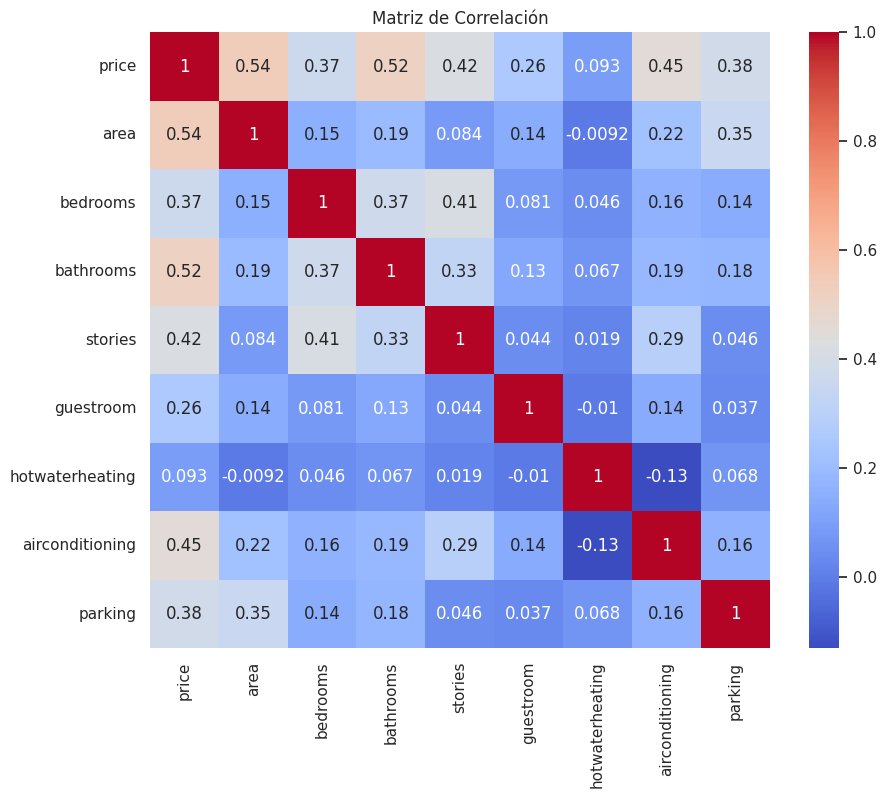

In [ ]:
# Matriz de correlación y mapa de calor
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

3. Análisis Detallado de Variables Individuales

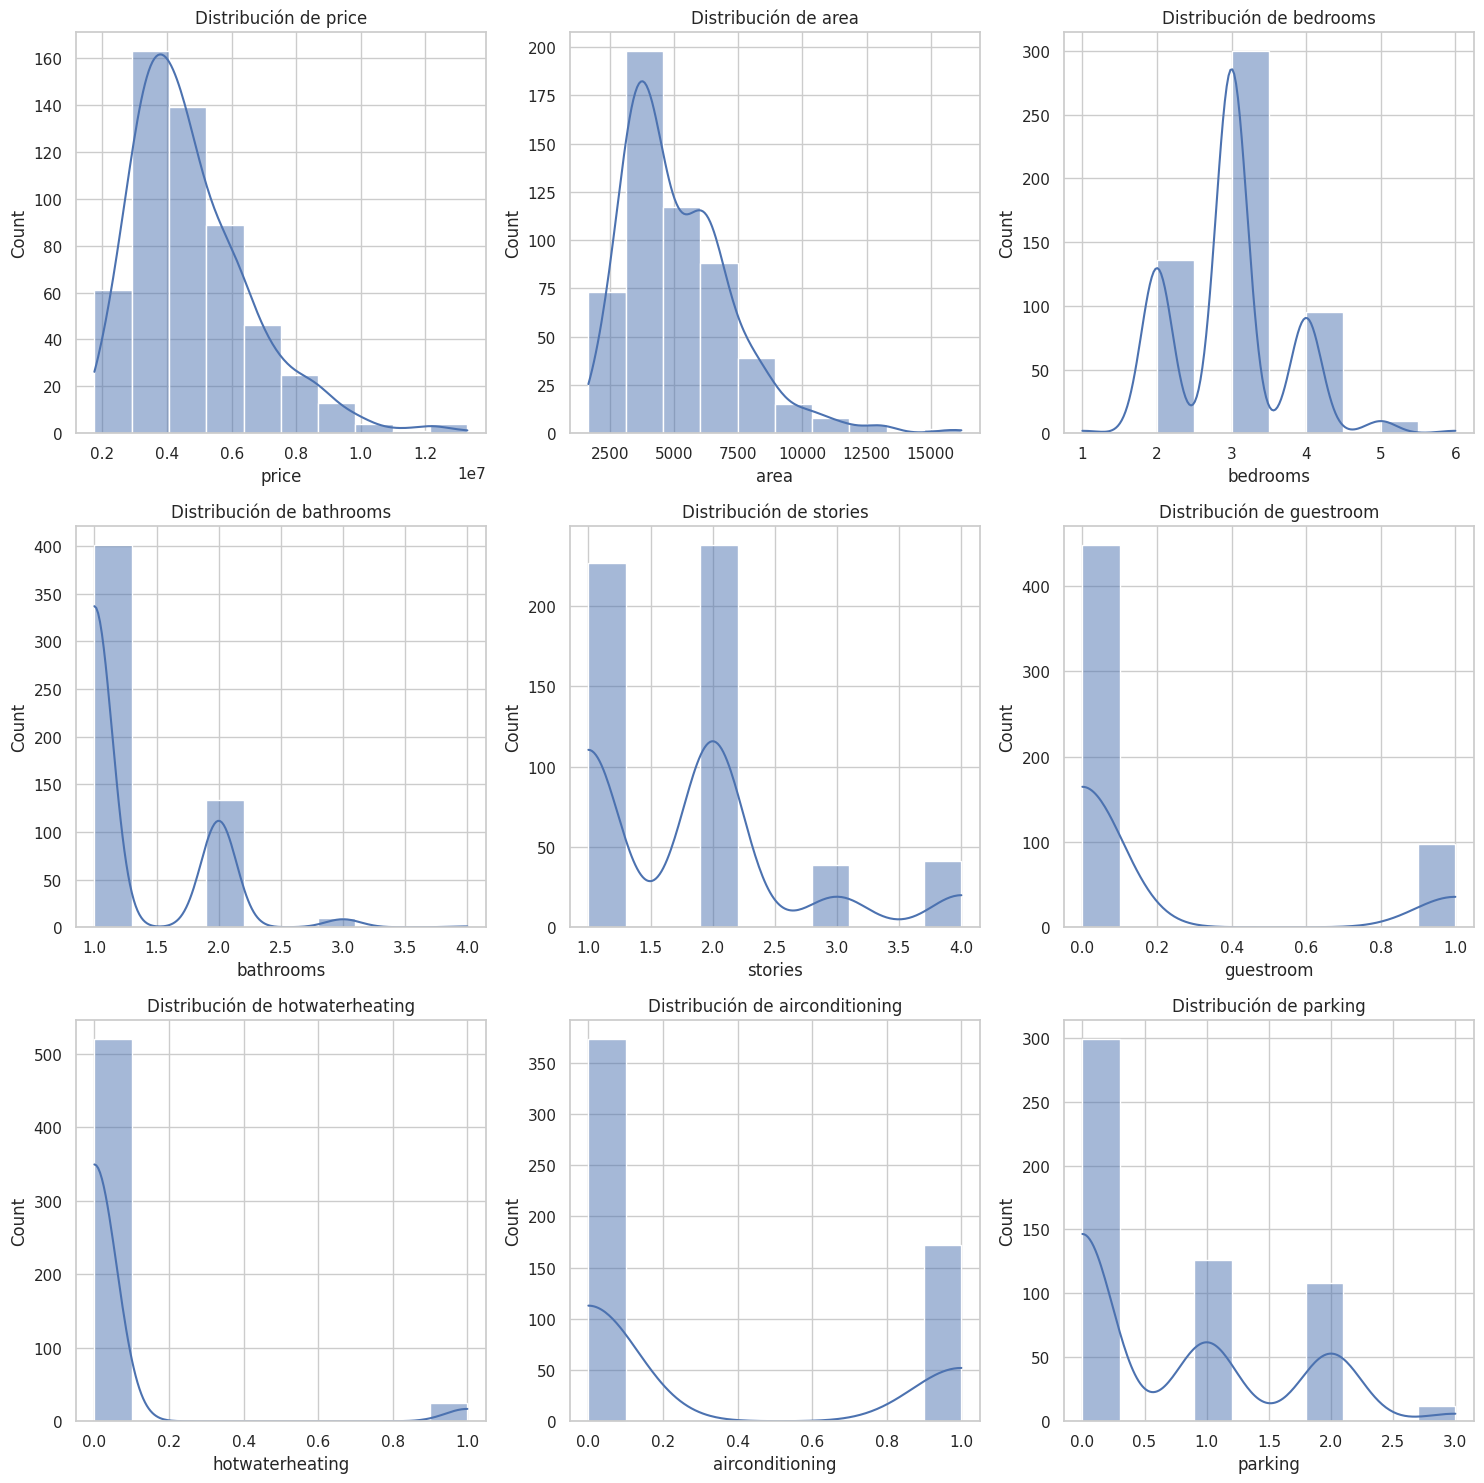

In [ ]:
# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Determinar el número de columnas y filas
num_columns = 3
num_rows = math.ceil(len(data.columns) / num_columns)

# Crear una figura y ejes
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))

# Iterar sobre las columnas y generar un histograma para cada una
for ax, column in zip(axes.flatten(), data.columns):
    sns.histplot(data[column], bins=10, kde=True, ax=ax)
    ax.set_title(f'Distribución de {column}')

# Eliminar los ejes vacíos
for i in range(len(data.columns), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

# Ajustar el layout para que los gráficos no se solapen
plt.tight_layout()
plt.show()

#Etapa 3: Preparación de los Datos
1. Manejo de Valores Nulos

In [ ]:
# Identificar valores nulos
print(data.isnull().sum())

price              0
area               0
bedrooms           0
bathrooms          0
stories            0
guestroom          0
hotwaterheating    0
airconditioning    0
parking            0
dtype: int64


2. Identificación y Tratamiento de Outliers

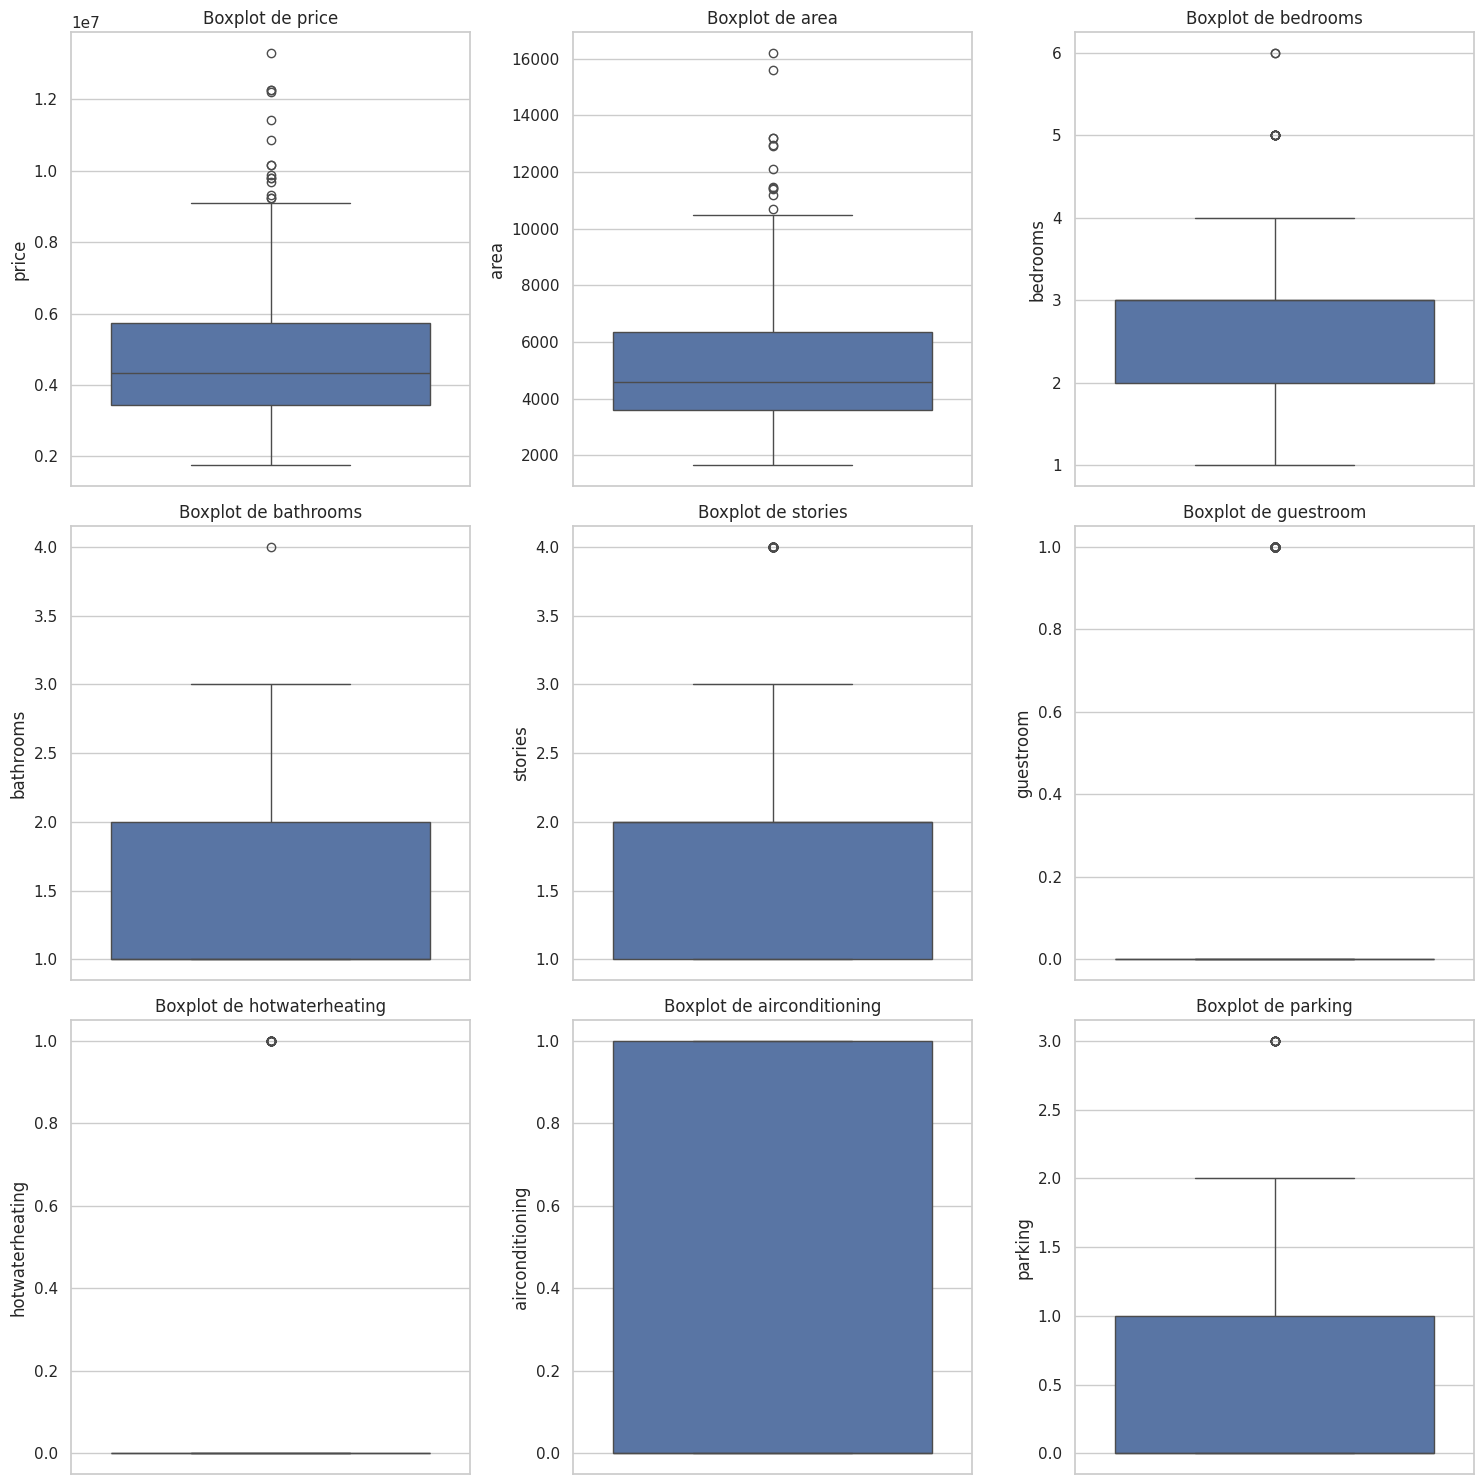

In [ ]:
# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Determinar el número de columnas y filas
num_columns = 3
num_rows = math.ceil(len(data.columns) / num_columns)

# Crear una figura y ejes
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))

# Iterar sobre las columnas y generar un boxplot para cada una
for ax, column in zip(axes.flatten(), data.columns):
    sns.boxplot(data=data[column], ax=ax)
    ax.set_title(f'Boxplot de {column}')

# Eliminar los ejes vacíos
for i in range(len(data.columns), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

# Ajustar el layout para que los gráficos no se solapen
plt.tight_layout()
plt.show()

In [ ]:
# Identificación de outliers usando el método del rango intercuartílico (IQR)
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Filtrado de outliers
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Verificación de la eliminación de outliers
print(data.shape)

(367, 9)


3. Normalización y Escalado de Datos

In [ ]:
# Normalización de los datos numéricos
scaler = StandardScaler()
numeric_features = ['area', 'bedrooms', 'bathrooms', 'stories']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

4. Generación de Nuevas Características

In [ ]:
# Generación de nuevas características (feature engineering)
data['relacion_tamaño_habitaciones'] = data['area'] / data['bedrooms']
data['baños_por_habitacion'] = data['bathrooms'] / data['bedrooms']

##Preparación Final de los Datos
División de Datos en Entrenamiento y Prueba

In [ ]:
# Definición de las variables predictoras y objetivo
X = data.drop(columns=['price'])
y = data['price']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Modelado
1. Definición de Pipelines y Modelos
Pipeline para Regresión Lineal

In [ ]:
from sklearn.linear_model import LinearRegression

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

Pipeline para Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

Pipeline para Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

2. Búsqueda de Hiperparámetros y Cross-Validation

Random Forest

In [ ]:
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', RandomForestRegressor())]),
             param_grid={'model__max_depth': [10, 20, None],
                         'model__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

Ridge Regression

In [ ]:
param_grid_ridge = {
    'model__alpha': [0.1, 1.0, 10.0]
}

grid_search_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Ridge())]),
             param_grid={'model__alpha': [0.1, 1.0, 10.0]},
             scoring='neg_mean_squared_error')

#Evaluación
Evaluación de Modelos con K-Fold Cross-Validation

In [ ]:
# Mejor modelo de Random Forest
best_rf = grid_search_rf.best_estimator_
best_ridge = grid_search_ridge.best_estimator_

# Predicciones en el set de prueba
y_pred_rf = best_rf.predict(X_test)
y_pred_ridge = best_ridge.predict(X_test)

# Métricas para Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Métricas para Ridge Regression
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'Random Forest - MSE: {mse_rf}, R2: {r2_rf}')
print(f'Ridge Regression - MSE: {mse_ridge}, R2: {r2_ridge}')

Random Forest - MSE: 1621899988826.611, R2: 0.3206941508676373
Ridge Regression - MSE: 1319434833317.0723, R2: 0.4473766533103479
